# Project 1 CNN Part

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce RTX 3060 Ti


In [1]:
# Set the hyperparameters
learning_rate = 0.0001
batch_size = 100
num_epochs = 50

## Data exploration

In [3]:
from numpy.random.mtrand import normal
# From pytorch dataset
aug2_transform = transforms.Compose([transforms.RandomRotation(degrees=18, fill=(0,)),
                                     transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])

aug_transform = transforms.Compose([transforms.RandAugment(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

normal_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

whole_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=aug_transform, download=False)
test_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=normal_transform, download=False)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=normal_transform, download=False)

In [ ]:
## Split train dataset for validation (Uncomment this cell if you need)

# num_train = len(whole_train_dataset)
# indices = list(range(num_train))
# val_size = 10000

# val_idx = np.random.choice(indices, size=val_size, replace=False)
# train_idx = list(set(indices) - set(val_idx))

# train_sampler = SubsetRandomSampler(train_idx)
# val_sampler = SubsetRandomSampler(val_idx

# val_loader = torch.utils.data.DataLoader(whole_train_dataset,
#                                          batch_size=batch_size,
#                                          num_workers=2,
#                                          sampler=val_sampler)

In [4]:
# Create Dataloader
train_loader = torch.utils.data.DataLoader(whole_train_dataset,
                                           batch_size=batch_size,
                                           num_workers=2)
                                           # sampler=train_sampler) 

## Uncomment this train loader if you use validation
# train_loader = torch.utils.data.DataLoader(whole_train_dataset,
#                                            batch_size=batch_size,
#                                            num_workers=2,
#                                            sampler=train_sampler) 

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=len(test_dataset),
                                          num_workers=2,
                                          shuffle=True)

test_train_loader = torch.utils.data.DataLoader(test_train_dataset,
                                                batch_size=len(test_train_dataset),
                                                num_workers=2)

torch.Size([100, 1, 28, 28])


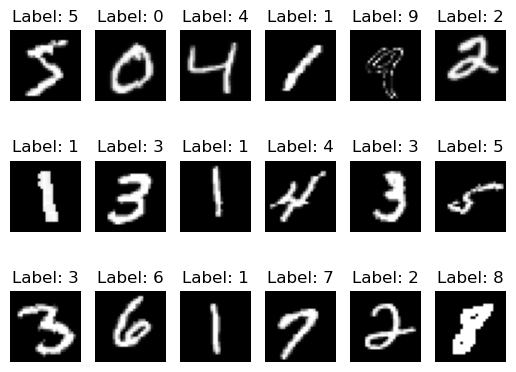

In [6]:
# Visualization of dataset, see the augmentation
batch_idx, (data, target) = next(enumerate(train_loader, 0))
print(data.shape)

fig = plt.figure()
for i in range(18):
  plt.subplot(3, 6, i+1)
  plt.imshow(data[i][0], cmap='gray')
  plt.title('Label: {}'.format(target[i]))
  plt.axis(False)

## Model design

In [11]:
# Traditional CNN
class Cnn_mnist(nn.Module):
    '''
    Convolution neural net work with 2 convolution layers and 2 fully connected layers.
    '''

    def __init__(self):
        super(Cnn_mnist, self).__init__()
        # Convolution layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv1_drop = nn.Dropout2d(0.3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.mp2 = nn.MaxPool2d(4)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2_drop = nn.Dropout2d(0.3)

        # Fully connect layer
        self.fc1 = nn.Linear(1152, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp1(self.conv1_drop(self.bn1(self.conv1(x)))))
        x = F.relu(self.mp2(self.conv2_drop(self.bn2(self.conv2(x)))))
        x = x.view(in_size, -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [22]:
# Validate the availibility of model
batch_idx, (data, target) = next(enumerate(train_loader, 0))
model = Cnn_mnist()
outputs = model(data)

print(data.shape)
print(outputs.shape)
print(model)

torch.Size([100, 1, 28, 28])
torch.Size([100, 10])
Cnn_mnist(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_drop): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (mp2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [23]:
def get_parameter_number(model):
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
   
    print(f'\nTotal params: {total_num}, Trainable params: {trainable_num}')

get_parameter_number(model)

conv1.weight : torch.Size([64, 1, 5, 5])
conv1.bias : torch.Size([64])
bn1.weight : torch.Size([64])
bn1.bias : torch.Size([64])
conv2.weight : torch.Size([128, 64, 3, 3])
conv2.bias : torch.Size([128])
bn2.weight : torch.Size([128])
bn2.bias : torch.Size([128])
fc1.weight : torch.Size([256, 1152])
fc1.bias : torch.Size([256])
bn3.weight : torch.Size([256])
bn3.bias : torch.Size([256])
fc2.weight : torch.Size([10, 256])
fc2.bias : torch.Size([10])

Total params: 374154, Trainable params: 374154


In [24]:
# Inception CNN
class Inception(nn.Module):
    '''
    Inception helper for building inception layer.
    Output channels: 88
    '''
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        
        self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)
        
        self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)
        
        self.branch3x3_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)
        
    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return torch.cat(outputs, 1)

    
class Inception_mnist(nn.Module):
    '''
    Convolution neural network with 2 convolution layers connected with a inception layer.
    Two fully connected layers for output.
    '''
    def __init__(self):
        super(Inception_mnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding='same')
        self.bn1 = nn.BatchNorm2d(64)
        self.incept1 = Inception(in_channels=64)
        self.bn2 = nn.BatchNorm2d(88)
        self.conv2 = nn.Conv2d(88, 128, kernel_size=3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        # self.incept2 = Inception(in_channels=128)
        # self.bn4 = nn.BatchNorm2d(88)
        
        self.mp = nn.MaxPool2d(2)
        self.conv_drop = nn.Dropout2d(0.3)
        
        self.fc1 = nn.Linear(6272, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv_drop(self.bn1(self.conv1(x)))))
        x = self.conv_drop(self.bn2(self.incept1(x)))
        x = F.relu(self.mp(self.bn3(self.conv_drop(self.conv2(x)))))
        # x = self.conv_drop(self.bn4(self.incept2(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [25]:
# Validate the availibility of model
batch_idx, (data, target) = next(enumerate(train_loader, 0))
model = Inception_mnist()
outputs = model(data)

print(data.shape)
print(outputs.shape)
print(model)

torch.Size([100, 1, 28, 28])
torch.Size([100, 10])
Inception_mnist(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (incept1): Inception(
    (branch1x1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch5x5_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch_pool): Conv2d(64, 24, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3x3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3x3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (bn2): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(88, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0

In [27]:
get_parameter_number(model)

conv1.weight : torch.Size([64, 1, 5, 5])
conv1.bias : torch.Size([64])
bn1.weight : torch.Size([64])
bn1.bias : torch.Size([64])
incept1.branch1x1.weight : torch.Size([16, 64, 1, 1])
incept1.branch1x1.bias : torch.Size([16])
incept1.branch5x5_1.weight : torch.Size([16, 64, 1, 1])
incept1.branch5x5_1.bias : torch.Size([16])
incept1.branch5x5_2.weight : torch.Size([24, 16, 5, 5])
incept1.branch5x5_2.bias : torch.Size([24])
incept1.branch_pool.weight : torch.Size([24, 64, 1, 1])
incept1.branch_pool.bias : torch.Size([24])
incept1.branch3x3_1.weight : torch.Size([16, 64, 1, 1])
incept1.branch3x3_1.bias : torch.Size([16])
incept1.branch3x3_2.weight : torch.Size([24, 16, 3, 3])
incept1.branch3x3_2.bias : torch.Size([24])
incept1.branch3x3_3.weight : torch.Size([24, 24, 3, 3])
incept1.branch3x3_3.bias : torch.Size([24])
bn2.weight : torch.Size([88])
bn2.bias : torch.Size([88])
conv2.weight : torch.Size([128, 88, 3, 3])
conv2.bias : torch.Size([128])
bn3.weight : torch.Size([128])
bn3.bias : t

## Model training

In [36]:
# Function for trainig
def train_model(model, model_name, train_loader, val_loader, epochs, optimizer, criterion, validation=True, visualization=False, early_stop=True, save_model=True):

    model.to(device)
    print('================================================================')
    train_step = len(train_loader)
    val_step = len(val_loader)
    total_loss_train = []
    total_acc_train = []
    total_loss_val = []
    total_acc_val = []
    best_acc = -float('inf')

    # Early stop step
    if early_stop:
        patience = 4
        best_loss = float('inf')
        cnt = 0
        min_delta = 0.0005

    for epoch in range(epochs):
        running_loss = 0
        running_acc = 0
        # Training step
        model.train()
        start = time.time()
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_loss = criterion(outputs, targets)
            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
            running_acc += (targets==predicted).sum().item()
            
        end = time.time()
        epoch_loss = running_loss / train_step
        epoch_acc = 100 / batch_size * running_acc / train_step
        total_loss_train.append(epoch_loss)
        total_acc_train.append(epoch_acc)
        
        
        print('Epoch {} (time usage: {:.2f}s):'.format(epoch+1, end - start))
        print('Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))

        # Evaluate in validation set
        if validation:
            model.eval()
            with torch.no_grad():
                running_loss = 0
                running_acc = 0
                total = 0
                for idx, (inputs, targets) in enumerate(val_loader):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)

                    val_loss = criterion(outputs, targets)
                    total += targets.size(0)
                    running_acc += (predicted == targets).sum().item()
                    running_loss += val_loss.item()
            epoch_loss = running_loss / val_step
            epoch_acc = 100.0 * running_acc / total
            total_loss_val.append(epoch_loss)
            total_acc_val.append(epoch_acc)
            print('Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))
            
            if save_model:
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), './model/{}.pth'.format(model_name))
                
        
        

        print('================================================================')

        # Whether early top
        if early_stop:
            if  epoch_loss < best_loss - min_delta:
                best_loss = epoch_loss
                cnt = 0
            else:
                cnt += 1
            if cnt >= patience:
                break


    # Visualization
    if visualization:
        plt.figure(figsize=(14, 5))
        plt.subplot(121)
        plt.plot(total_loss_train, label='train loss')
        if validation:
            plt.plot(total_loss_val, label='validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(122)
        plt.plot(total_acc_train, label='train acc')
        if validation:
            plt.plot(total_acc_val, label='validation acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value / %')
        plt.legend()

        plt.show()


Epoch 1 (time usage: 15.28s):
Loss: 1.1082, Accuracy: 67.65%
Val_Loss: 0.2103, Val_Accuracy: 95.41%
Epoch 2 (time usage: 13.28s):
Loss: 0.4737, Accuracy: 87.31%
Val_Loss: 0.0943, Val_Accuracy: 97.31%
Epoch 3 (time usage: 13.34s):
Loss: 0.3380, Accuracy: 90.35%
Val_Loss: 0.0629, Val_Accuracy: 98.15%
Epoch 4 (time usage: 13.36s):
Loss: 0.2715, Accuracy: 92.06%
Val_Loss: 0.0486, Val_Accuracy: 98.38%
Epoch 5 (time usage: 13.36s):
Loss: 0.2353, Accuracy: 93.10%
Val_Loss: 0.0402, Val_Accuracy: 98.73%
Epoch 6 (time usage: 13.53s):
Loss: 0.2136, Accuracy: 93.61%
Val_Loss: 0.0346, Val_Accuracy: 98.84%
Epoch 7 (time usage: 13.28s):
Loss: 0.1969, Accuracy: 94.07%
Val_Loss: 0.0314, Val_Accuracy: 98.92%
Epoch 8 (time usage: 13.43s):
Loss: 0.1850, Accuracy: 94.33%
Val_Loss: 0.0288, Val_Accuracy: 98.95%
Epoch 9 (time usage: 13.49s):
Loss: 0.1748, Accuracy: 94.62%
Val_Loss: 0.0268, Val_Accuracy: 99.01%
Epoch 10 (time usage: 13.55s):
Loss: 0.1663, Accuracy: 94.86%
Val_Loss: 0.0244, Val_Accuracy: 99.16%

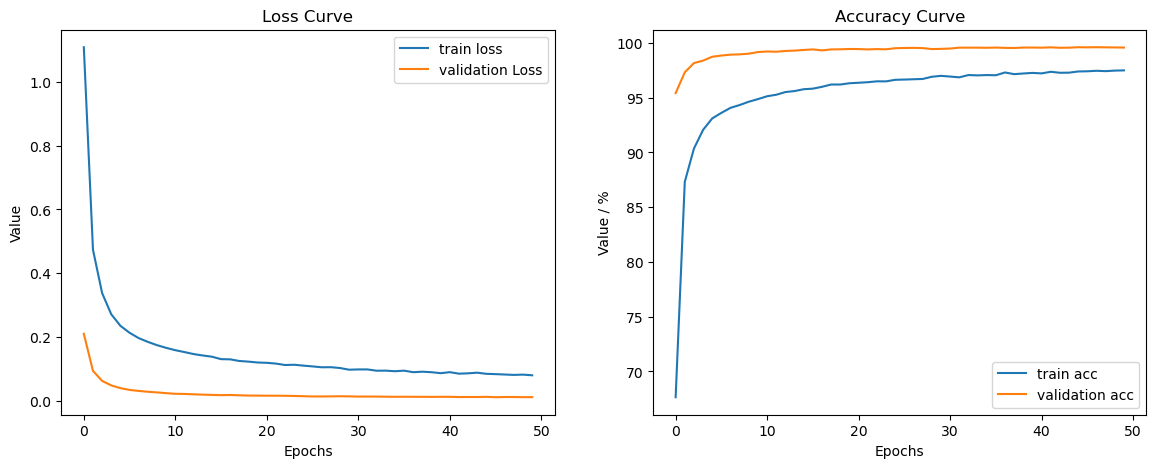

In [42]:
# Classic model
cnn_model = Cnn_mnist()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-08, weight_decay=0.000)

train_model(model=cnn_model,
            model_name='Classic_cnn',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 14.01s):
Loss: 0.6774, Accuracy: 81.72%
Val_Loss: 0.1013, Val_Accuracy: 97.14%
Epoch 2 (time usage: 13.73s):
Loss: 0.2720, Accuracy: 92.82%
Val_Loss: 0.0572, Val_Accuracy: 98.31%
Epoch 3 (time usage: 13.84s):
Loss: 0.2010, Accuracy: 94.37%
Val_Loss: 0.0403, Val_Accuracy: 98.75%
Epoch 4 (time usage: 13.70s):
Loss: 0.1638, Accuracy: 95.27%
Val_Loss: 0.0317, Val_Accuracy: 98.99%
Epoch 5 (time usage: 13.61s):
Loss: 0.1437, Accuracy: 95.83%
Val_Loss: 0.0277, Val_Accuracy: 99.11%
Epoch 6 (time usage: 13.58s):
Loss: 0.1312, Accuracy: 96.14%
Val_Loss: 0.0262, Val_Accuracy: 99.23%
Epoch 7 (time usage: 13.81s):
Loss: 0.1193, Accuracy: 96.46%
Val_Loss: 0.0217, Val_Accuracy: 99.25%
Epoch 8 (time usage: 13.68s):
Loss: 0.1080, Accuracy: 96.80%
Val_Loss: 0.0213, Val_Accuracy: 99.27%
Epoch 9 (time usage: 13.63s):
Loss: 0.1003, Accuracy: 96.94%
Val_Loss: 0.0204, Val_Accuracy: 99.21%
Epoch 10 (time usage: 13.89s):
Loss: 0.0937, Accuracy: 97.11%
Val_Loss: 0.0199, Val_Accuracy: 99.29%

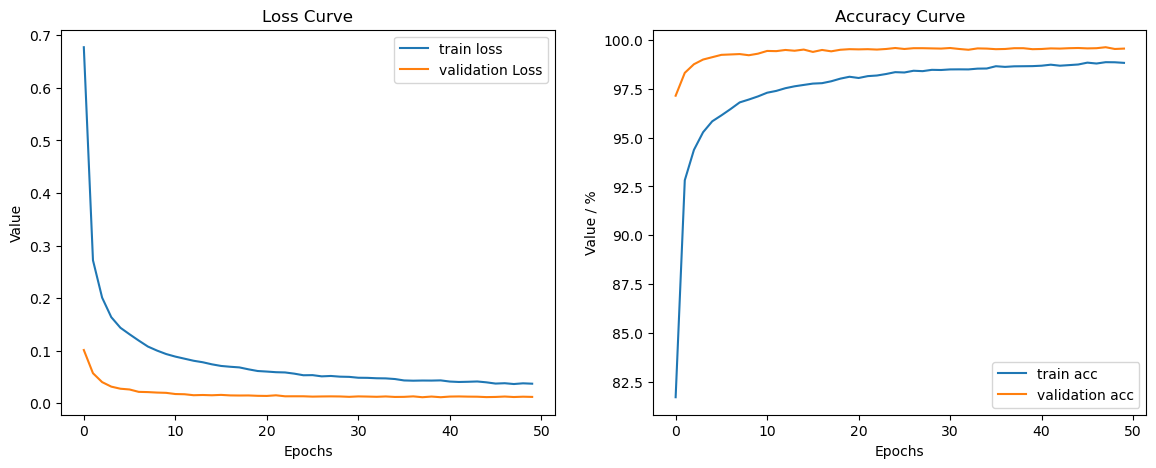

In [41]:
# Inception model
cnn_model = Inception_mnist()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-08, weight_decay=0.000)

train_model(model=cnn_model,
            model_name='Inception_cnn',
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 13.57s):
Loss: 1.0988, Accuracy: 68.08%
Val_Loss: 0.1941, Val_Accuracy: 95.71%
Epoch 2 (time usage: 13.52s):
Loss: 0.4411, Accuracy: 88.21%
Val_Loss: 0.0831, Val_Accuracy: 97.65%
Epoch 3 (time usage: 13.57s):
Loss: 0.3148, Accuracy: 91.09%
Val_Loss: 0.0580, Val_Accuracy: 98.27%
Epoch 4 (time usage: 13.70s):
Loss: 0.2605, Accuracy: 92.45%
Val_Loss: 0.0457, Val_Accuracy: 98.61%
Epoch 5 (time usage: 13.68s):
Loss: 0.2283, Accuracy: 93.25%
Val_Loss: 0.0384, Val_Accuracy: 98.83%
Epoch 6 (time usage: 13.62s):
Loss: 0.2063, Accuracy: 93.83%
Val_Loss: 0.0344, Val_Accuracy: 98.96%
Epoch 7 (time usage: 13.62s):
Loss: 0.1913, Accuracy: 94.42%
Val_Loss: 0.0301, Val_Accuracy: 99.01%
Epoch 8 (time usage: 13.65s):
Loss: 0.1802, Accuracy: 94.66%
Val_Loss: 0.0266, Val_Accuracy: 99.15%
Epoch 9 (time usage: 13.62s):
Loss: 0.1739, Accuracy: 94.82%
Val_Loss: 0.0255, Val_Accuracy: 99.17%
Epoch 10 (time usage: 13.89s):
Loss: 0.1658, Accuracy: 95.09%
Val_Loss: 0.0236, Val_Accuracy: 99.23%

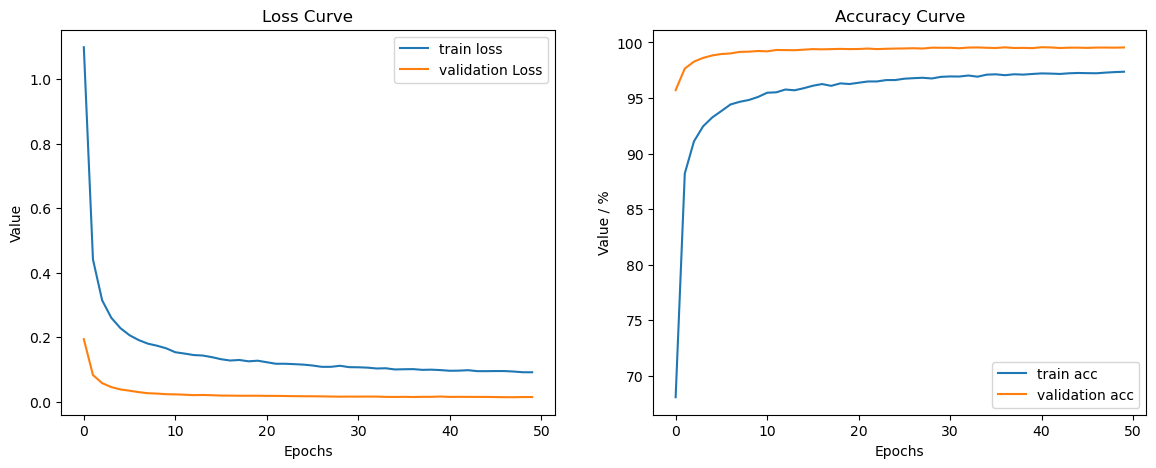

In [124]:
cnn_model = Cnn_mnist()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.99), eps=1e-08, weight_decay=0.001)

train_model(model=cnn_model,
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 14.52s):
Loss: 1.1154, Accuracy: 67.32%
Val_Loss: 0.2086, Val_Accuracy: 95.53%
Epoch 2 (time usage: 14.90s):
Loss: 0.4781, Accuracy: 87.09%
Val_Loss: 0.0911, Val_Accuracy: 97.40%
Epoch 3 (time usage: 14.59s):
Loss: 0.3328, Accuracy: 90.51%
Val_Loss: 0.0589, Val_Accuracy: 98.30%
Epoch 4 (time usage: 14.58s):
Loss: 0.2761, Accuracy: 91.90%
Val_Loss: 0.0470, Val_Accuracy: 98.54%
Epoch 5 (time usage: 14.89s):
Loss: 0.2392, Accuracy: 92.78%
Val_Loss: 0.0387, Val_Accuracy: 98.77%
Epoch 6 (time usage: 14.61s):
Loss: 0.2151, Accuracy: 93.46%
Val_Loss: 0.0330, Val_Accuracy: 98.93%
Epoch 7 (time usage: 14.60s):
Loss: 0.1947, Accuracy: 94.05%
Val_Loss: 0.0292, Val_Accuracy: 99.10%
Epoch 8 (time usage: 14.57s):
Loss: 0.1908, Accuracy: 94.16%
Val_Loss: 0.0273, Val_Accuracy: 99.06%
Epoch 9 (time usage: 15.04s):
Loss: 0.1781, Accuracy: 94.64%
Val_Loss: 0.0252, Val_Accuracy: 99.20%
Epoch 10 (time usage: 14.69s):
Loss: 0.1633, Accuracy: 94.98%
Val_Loss: 0.0235, Val_Accuracy: 99.25%

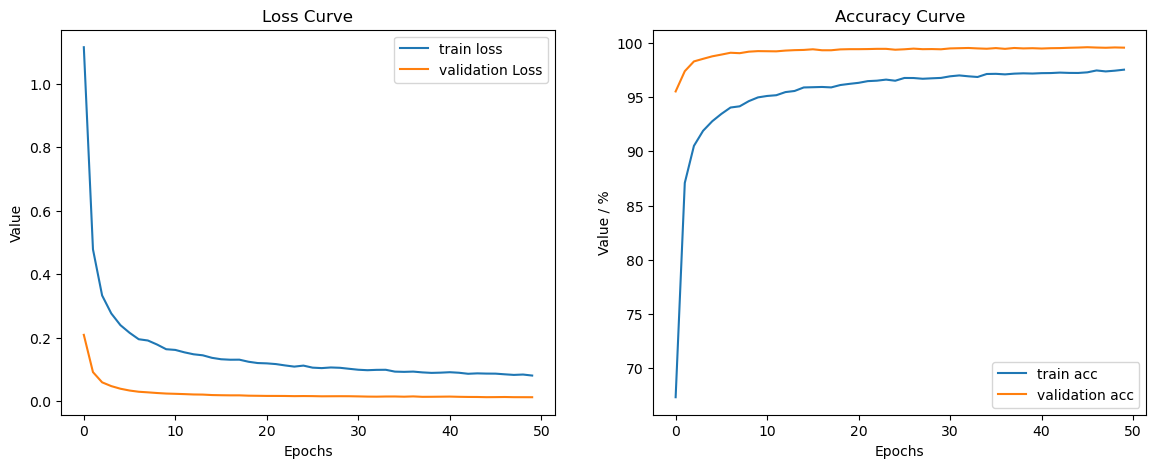

In [125]:
cnn_model = Cnn_mnist()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate, betas=(0.9,0.999), eps=1e-08, weight_decay=0.000)

train_model(model=cnn_model,
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 13.93s):
Loss: 1.1012, Accuracy: 68.08%
Val_Loss: 0.2041, Val_Accuracy: 95.53%
Epoch 2 (time usage: 13.41s):
Loss: 0.4676, Accuracy: 87.64%
Val_Loss: 0.0954, Val_Accuracy: 97.36%
Epoch 3 (time usage: 13.59s):
Loss: 0.3376, Accuracy: 90.50%
Val_Loss: 0.0635, Val_Accuracy: 98.11%
Epoch 4 (time usage: 13.38s):
Loss: 0.2710, Accuracy: 92.14%
Val_Loss: 0.0489, Val_Accuracy: 98.49%
Epoch 5 (time usage: 13.35s):
Loss: 0.2351, Accuracy: 93.04%
Val_Loss: 0.0408, Val_Accuracy: 98.69%
Epoch 6 (time usage: 13.34s):
Loss: 0.2134, Accuracy: 93.53%
Val_Loss: 0.0364, Val_Accuracy: 98.79%
Epoch 7 (time usage: 13.59s):
Loss: 0.1987, Accuracy: 93.89%
Val_Loss: 0.0322, Val_Accuracy: 98.93%
Epoch 8 (time usage: 13.31s):
Loss: 0.1845, Accuracy: 94.38%
Val_Loss: 0.0291, Val_Accuracy: 99.08%
Epoch 9 (time usage: 13.62s):
Loss: 0.1700, Accuracy: 94.71%
Val_Loss: 0.0273, Val_Accuracy: 99.15%
Epoch 10 (time usage: 13.54s):
Loss: 0.1645, Accuracy: 94.96%
Val_Loss: 0.0248, Val_Accuracy: 99.17%

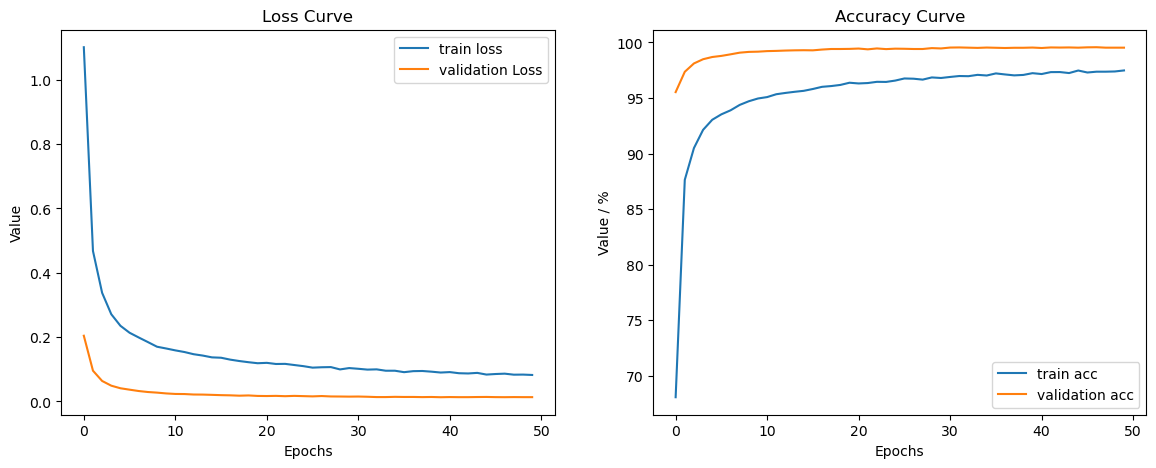

In [72]:
train_model(model=cnn_model,
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=num_epochs,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

In [112]:
cnn_model = Cnn_mnist()
criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS(cnn_model.parameters(), line_search_fn='strong_wolfe')

train_model(model=cnn_model,
            train_loader=train_loader,
            val_loader=test_loader,
            epochs=20,
            optimizer=optimizer,
            criterion=criterion,
            visualization=True, early_stop=False)

Epoch 1 (time usage: 13.57s):
Loss: 2.4485, Accuracy: 10.00%
Val_Loss: 2.3250, Val_Accuracy: 7.15%
Epoch 2 (time usage: 13.44s):
Loss: 2.4490, Accuracy: 9.74%
Val_Loss: 2.3264, Val_Accuracy: 7.06%


KeyboardInterrupt: 

In [111]:


def train_model(model, train_loader, val_loader, epochs, optimizer, criterion, validation=True, visualization=False, early_stop=True):

    model.to(device)
    print('================================================================')
    train_step = len(train_loader)
    val_step = len(val_loader)
    total_loss_train = []
    total_acc_train = []
    total_loss_val = []
    total_acc_val = []

    # Early stop step
    if early_stop:
        patience = 4
        best_loss = float('inf')
        cnt = 0
        min_delta = 0.0005

    for epoch in range(epochs):
        running_loss = 0
        running_acc = 0
        # Training step
        model.train()
        start = time.time()
        
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            # optimizer.zero_grad()
            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                return loss

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            train_loss = criterion(outputs, targets)
            # train_loss.backward()
            optimizer.step(closure)

            running_loss += train_loss.item()
            running_acc += (targets==predicted).sum().item()
            
        end = time.time()
        epoch_loss = running_loss / train_step
        epoch_acc = 100 / batch_size * running_acc / train_step
        total_loss_train.append(epoch_loss)
        total_acc_train.append(epoch_acc)
        
        
        print('Epoch {} (time usage: {:.2f}s):'.format(epoch+1, end - start))
        print('Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))

        # Evaluate in validation set
        if validation:
            model.eval()
            with torch.no_grad():
                running_loss = 0
                running_acc = 0
                total = 0
                for idx, (inputs, targets) in enumerate(val_loader):
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)

                    val_loss = criterion(outputs, targets)
                    total += targets.size(0)
                    running_acc += (predicted == targets).sum().item()
                    running_loss += val_loss.item()
            epoch_loss = running_loss / val_step
            epoch_acc = 100.0 * running_acc / total
            total_loss_val.append(epoch_loss)
            total_acc_val.append(epoch_acc)
            print('Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%'.format(epoch_loss, epoch_acc))

        print('================================================================')

        # Whether early top
        if early_stop:
            if  epoch_loss < best_loss - min_delta:
                best_loss = epoch_loss
                cnt = 0
            else:
                cnt += 1
            if cnt >= patience:
                break


    # Visualization
    if visualization:
        plt.figure(figsize=(14, 5))
        plt.subplot(121)
        plt.plot(total_loss_train, label='train loss')
        if validation:
            plt.plot(total_loss_val, label='validation Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(122)
        plt.plot(total_acc_train, label='train acc')
        if validation:
            plt.plot(total_acc_val, label='validation acc')
        plt.title('Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Value / %')
        plt.legend()

        plt.show()


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Evaluation function
def evaluate_model(model, test_loader):
  model.eval()
  inputs, targets = next(iter(test_loader))
  outputs = model(inputs)
  _, predicted = torch.max(outputs, 1)

  print('Performance: ')
  print(classification_report(targets, predicted))
  print('Confusion matrix:')
  print(confusion_matrix(targets, predicted))
  print('\nACCURACY: {}'.format(accuracy_score(targets, predicted)))



In [17]:
evaluate_model(cnn_model, test_loader=train_loader)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor